# Text Classification with GLMNet

Classification using regularized elastic net.

In [1]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Books_Writings/NLPBook/')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
%%capture
%pylab inline
import pandas as pd
import os
%load_ext rpy2.ipython

In [ ]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

## Text Classification using GLMNet

The large movie review dataset is here: https://ai.stanford.edu/~amaas/data/sentiment/
        
For an excellent description of glmnet see: https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html

Let's move over to the R program to run GLMNet, as it was written for that environmemt. We will execute the %%R code blocks in a separate notebook with a R kernel.

In [ ]:
%%R
install.packages(c("data.table","magrittr"), quiet=TRUE)
# !conda install -c r r-data.table r-magrittr -y

In [ ]:
%%R
install.packages("glmnet", quiet=TRUE) # long install
# !conda install -c conda-forge glmnet -y

In [ ]:
%%R
install.packages(c("text2vec"), quiet=TRUE) # VERY LONG INSTALL
# !conda install -c conda-forge r-text2vec -y   # Need the -y to not have to answer 'y' after packages are detected

In [ ]:
%%R
library(text2vec)
library(data.table)

In [ ]:
%%R
data("movie_review")
setDT(movie_review)
setkey(movie_review, id)
set.seed(2016L)
all_ids = movie_review$id
train_ids = sample(all_ids, 4000)
test_ids = setdiff(all_ids, train_ids)
train = movie_review[J(train_ids)]
test = movie_review[J(test_ids)]

print(head(train))

         id sentiment
     <char>     <int>
1:   6748_8         1
2:   1294_7         1
3: 11206_10         1
4:  1217_10         1
5:  10395_8         1
6:   6531_8         1
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [ ]:
%%R
# Get from R into python, through csv file
write.csv(movie_review, "NLP_data/movie_review.csv", row.names=FALSE)

In [ ]:
mr = pd.read_csv("NLP_data/movie_review.csv")
print(mr.shape)
mr.head()

(5000, 3)


id  sentiment                                             review
0  10000_8          1  Homelessness (or Houselessness as George Carli...
1  10001_4          0  This film lacked something I couldn't put my f...
2  10004_3          0  \"It appears that many critics find the idea o...
3  10004_8          1  This isn't the comedic Robin Williams, nor is ...
4  10006_4          0  I don't know who to blame, the timid writers o...

In [ ]:
%%R
prep_fun = tolower
tok_fun = word_tokenizer

#Create an iterator to pass to the create_vocabulary function
it_train = itoken(train$review,
             preprocessor = prep_fun,
             tokenizer = tok_fun,
             ids = train$id,
             progressbar = FALSE)

#Now create a vocabulary
vocab = create_vocabulary(it_train)
print(vocab)

Number of docs: 4000 
0 stopwords:  ... 
ngram_min = 1; ngram_max = 1 
Vocabulary: 
         term term_count doc_count
       <char>      <int>     <int>
    1:   0.02          1         1
    2:    0.3          1         1
    3:   0.48          1         1
    4:    0.5          1         1
    5:   0.89          1         1
   ---                            
38457:     to      22238      3792
38458:     of      23604      3787
38459:      a      26609      3876
38460:    and      26950      3863
38461:    the      54281      3971


In [ ]:
%%R
vectorizer = vocab_vectorizer(vocab)
dtm_train = create_dtm(it_train, vectorizer)
print(dim(as.matrix(dtm_train)))
vocab = create_vocabulary(it_train, ngram = c(1, 2))
print(vocab)

[1]  4000 38461
Number of docs: 4000 
0 stopwords:  ... 
ngram_min = 1; ngram_max = 2 
Vocabulary: 
            term term_count doc_count
          <char>      <int>     <int>
     1:     0.02          1         1
     2: 0.02_out          1         1
     3:   0.0_10          1         1
     4: 0.0_it's          1         1
     5:      0.3          1         1
    ---                              
406974:       to      22238      3792
406975:       of      23604      3787
406976:        a      26609      3876
406977:      and      26950      3863
406978:      the      54281      3971


In [ ]:
%%R
library(glmnet)
library(magrittr)
NFOLDS = 5

vocab2 = vocab %>% prune_vocabulary(term_count_min = 10,
                   doc_proportion_max = 0.5)
print(vocab2)

Number of docs: 4000 
0 stopwords:  ... 
ngram_min = 1; ngram_max = 2 
Vocabulary: 
         term term_count doc_count
       <char>      <int>     <int>
    1:   1948         10         9
    2:   1951         10         9
    3:   1966         10         6
    4: 1970_s         10         9
    5:   1977         10        10
   ---                            
17700:   like       3374      1920
17701:   they       3403      1642
17702:     by       3642      1885
17703:     he       4240      1571
17704:    his       4688      1721


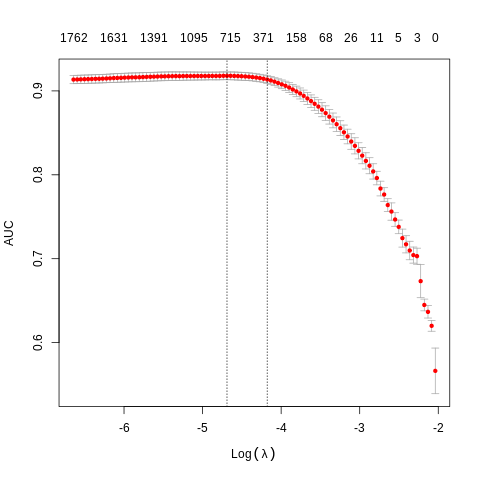

In [ ]:
%%R
bigram_vectorizer = vocab_vectorizer(vocab2)
dtm_train = create_dtm(it_train, bigram_vectorizer)
res = cv.glmnet(x = dtm_train, y = train[['sentiment']],
                 family = 'binomial',
                 alpha = 1,
                 type.measure = "auc",
                 nfolds = NFOLDS,
                 thresh = 1e-3,
                 maxit = 1e3)
plot(res)


In [ ]:
%%R
print(names(res))
cat("AUC (area under curve):")
print(max(res$cvm))

 [1] "lambda"     "cvm"        "cvsd"       "cvup"       "cvlo"      
 [6] "nzero"      "call"       "name"       "glmnet.fit" "lambda.min"
[11] "lambda.1se" "index"     
AUC (area under curve):[1] 0.9179888


In [ ]:
%%R
#Out-of-sample test
it_test = test$review %>%
  prep_fun %>%
  tok_fun %>%
  itoken(ids = test$id,
         # turn off progressbar because it won't look nice in rmd
         progressbar = FALSE)

dtm_test = create_dtm(it_test, bigram_vectorizer)
preds = predict(res, dtm_test, type = 'response')[,1]
glmnet:::auc(test$sentiment, preds)

[1] 0.9164907


In [ ]:
%%R
accuracy = mean(test$sentiment==round(preds))
accuracy

[1] 0.831


In [ ]:
%%R
res = glmnet(x = dtm_train,
             y = train[['sentiment']],
             family = 'binomial',
             alpha = 1,
             thresh = 1e-3,
             maxit = 1e3)

print(names(res))
print(res)

 [1] "a0"         "beta"       "df"         "dim"        "lambda"    
 [6] "dev.ratio"  "nulldev"    "npasses"    "jerr"       "offset"    
[11] "classnames" "call"       "nobs"      

Call:  glmnet(x = dtm_train, y = train[["sentiment"]], family = "binomial",      alpha = 1, thresh = 0.001, maxit = 1000) 

      Df  %Dev   Lambda
1      0  0.00 0.130300
2      1  0.44 0.124400
3      1  0.83 0.118700
4      2  1.25 0.113300
5      2  1.78 0.108200
6      3  2.32 0.103300
7      3  3.05 0.098570
8      3  3.71 0.094090
9      3  4.33 0.089820
10     4  5.04 0.085740
11     5  5.79 0.081840
12     6  6.63 0.078120
13     6  7.42 0.074570
14     7  8.26 0.071180
15     7  9.05 0.067940
16     9  9.95 0.064860
17    11 10.85 0.061910
18    12 11.76 0.059090
19    14 12.75 0.056410
20    17 13.74 0.053840
21    22 14.81 0.051400
22    24 15.94 0.049060
23    26 17.03 0.046830
24    26 18.11 0.044700
25    35 19.23 0.042670
26    37 20.35 0.040730
27    43 21.51 0.038880
28    49 22.70 0.03

In [ ]:
%%R
f = res$beta[,35]   # feature coefficients
non0f = f[which(f!=0)]
words = names(non0f)
words

  [1] "7_10"             "br_4"             "4_10"            
  [4] "well_worth"       "top_notch"        "8_10"            
  [7] "loved_it"         "not_worth"        "wonderfully"     
 [10] "avoid_this"       "at_best"          "sit_through"     
 [13] "outstanding"      "highly_recommend" "disappointment"  
 [16] "gem"              "a_must"           "disappointing"   
 [19] "laughable"        "garbage"          "wasted"          
 [22] "masterpiece"      "fails"            "pointless"       
 [25] "mess"             "poorly"           "lame"            
 [28] "badly"            "7"                "not_even"        
 [31] "unless"           "powerful"         "perfectly"       
 [34] "predictable"      "enjoyable"        "very_well"       
 [37] "8"                "fantastic"        "watching_this"   
 [40] "dull"             "today"            "annoying"        
 [43] "crap"             "simple"           "horrible"        
 [46] "amazing"          "favorite"         "highly"   

In [ ]:
%%R
wordcount = abs(non0f)
wordcount

            7_10             br_4             4_10       well_worth 
    0.1737067602     0.1537751279     0.3880592592     0.3721005173 
       top_notch             8_10         loved_it        not_worth 
    0.1157643996     0.1437147779     0.1253946762     0.2077053287 
     wonderfully       avoid_this          at_best      sit_through 
    0.0079554286     0.0036507740     0.0214432297     0.0607129705 
     outstanding highly_recommend   disappointment              gem 
    0.0047577937     0.0988630171     0.0818577027     0.1342509079 
          a_must    disappointing        laughable          garbage 
    0.1715726294     0.1759929460     0.2081529486     0.1119382095 
          wasted      masterpiece            fails        pointless 
    0.3001975722     0.0041195927     0.0058318612     0.1993796544 
            mess           poorly             lame            badly 
    0.2689532518     0.2970575815     0.1526924581     0.3828920110 
               7         not_even 

In [ ]:
%%R
print(names(vocab2))
all_words = vocab2$term
all_term_count = vocab2$term_count
all_doc_count = vocab2$doc_count

[1] "term"       "term_count" "doc_count" 


In [ ]:
words = %Rget words
wordcount = %Rget wordcount
all_words = %Rget all_words
all_term_count = %Rget all_term_count
all_doc_count = %Rget all_doc_count

In [ ]:
all_words = array([j for j in all_words])
all_term_count = array([j for j in all_term_count])
all_doc_count = array([j for j in all_doc_count])

In [ ]:
text = ""
for w in words:
    n = all_term_count[all_words==w][0]
    n = 1
    if n>0:
        for j in range(n):
            text = text + " " + w

(-0.5, 399.5, 199.5, -0.5)

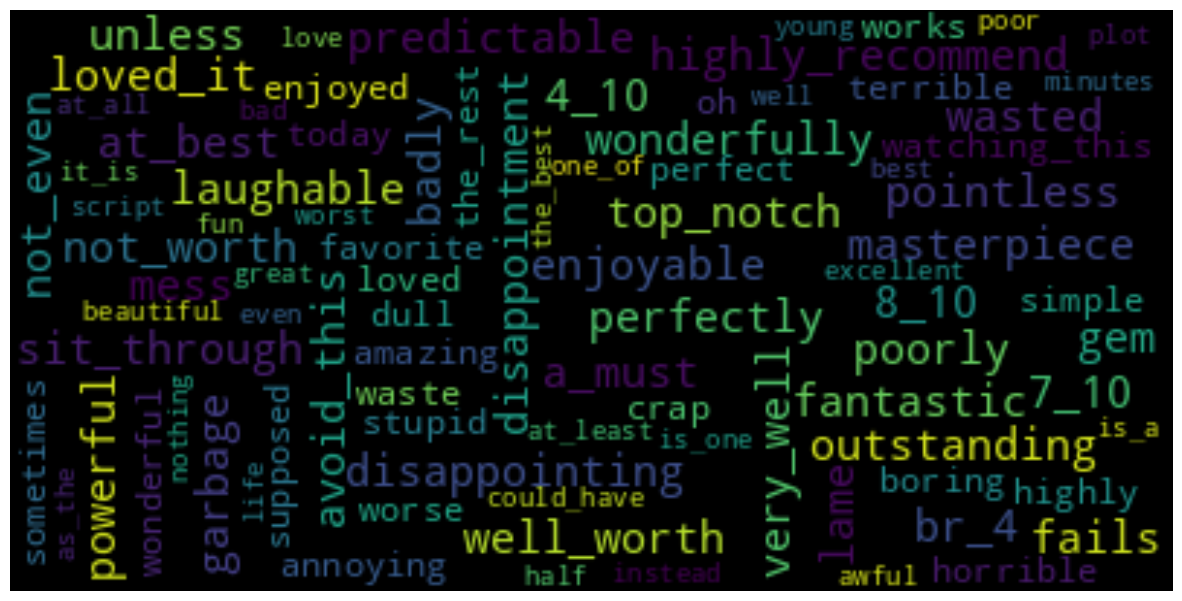

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=15).generate(text)

#Use pyplot from matplotlib
figure(figsize=(15,8))
pyplot.imshow(wordcloud, interpolation='bilinear')
pyplot.axis("off")